In [18]:
from __future__ import (absolute_import, division, print_function)
from six.moves import (filter, input, map, range, zip)  # noqa
import iris
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
import iris.analysis.cartography
import iris.coord_categorisation as icc
import numpy as np
from scipy import stats

In [10]:
slope_path = '/home/bschmidt/data/test_tas_slope.nc4'
intercept_path = '/home/bschmidt/data/test_tas_intercept.nc4'
gmt_path = '/home/bschmidt/data/test_gmt.nc4'
data_path = '/home/bschmidt/data/test_data_tas.nc4'

slope = iris.load_cube(slope_path)
slope.rename('slope')
slope.coord('dim0').rename('day_of_year')
intercept = iris.load_cube(intercept_path)
intercept.rename('intercept')
intercept.coord('dim0').rename('day_of_year')
gmt = iris.load_cube(gmt_path)
data = iris.load_cube(data_path)

icc.add_day_of_year(data, 'time')

#data.coord('latitude').guess_bounds()
#data.coord('longitude').guess_bounds()

#grid_areas = iris.analysis.cartography.area_weights(data)
#data_collapsed = data.collapsed(['longitude', 'latitude'], 
#                                iris.analysis.MEAN, 
#                                weights=grid_areas)
#print(data_collapsed)

print(gmt)
#fit = intercept.data[1, 0, 0] + (slope.data[1, 0, 0] * gmt)
#print(fit)

tas / (1)                           (time: 40177)
     Dimension coordinates:
          time                           x
     Auxiliary coordinates:
          day_of_year                    x
     Attributes:
          Conventions: CF-1.5
     Cell methods:
          mean: longitude, latitude


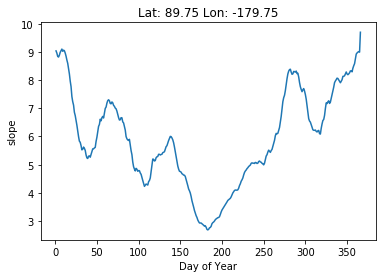

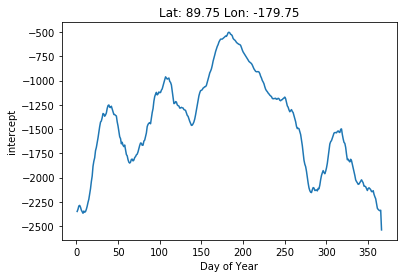

In [3]:
def plot_1d_doy(data, lat_ind, lon_ind):
    # Take a 1d slice with doy on x axis
    lat = data.coord('latitude').points[lat_ind]
    lon = data.coord('longitude').points[lon_ind]
    data_1d = data[:, lat_ind, lon_ind]
    fig = iplt.plot(data_1d)
    plt.title('Lat: ' + str(lat) + ' Lon: ' + str(lon))
    plt.xlabel('Day of Year')
    plt.ylabel(data.name())
    plt.show()

plot_1d_doy(slope, 0, 0)
plot_1d_doy(intercept, 0, 0)
#print(slope)


In [48]:
def regr_fit_gmt(slope, intercept, data, gmt, indices=(0, 0, 0), detrend=False):
    doy = slope.coord('day_of_year').points[indices[0]]
    lat = slope.coord('latitude').points[indices[1]]
    lon = slope.coord('longitude').points[indices[2]]
    slope = slope[indices]
    intercept = intercept[indices]
    plot_data = data.extract(iris.Constraint(day_of_year=indices[0]+1))
    plot_data = plot_data[:, indices[1], indices[2]]
    gmt = gmt.extract(iris.Constraint(day_of_year=indices[0]+1))
    fit = intercept.data + (slope.data * gmt.data)
    if detrend:
        plot_data = plot_data.data - fit + gmt.data[1]
        s, i, r, p, sd = stats.linregress(gmt.data[1:-1], plot_data[1:-1])
        fit = s*gmt.data + i
    # Plot the data of one point and fit the regression.
    plt.scatter(gmt.data[1:-1], plot_data.data[1:-1])
    plt.plot(gmt.data[1:-1], fit[1:-1], 'r', label='fit')
    plt.title('Doy: ' + str(doy) + ' Lat: ' + str(lat) + ' Lon: ' + str(lon))
    plt.xlabel('gmt / K')
    plt.ylabel(data.name() + ' / K')
    plt.legend(ncol=2)
    plt.grid(True)
    plt.axis('tight')
    iplt.show()
    plt.savefig('/home/bschmidt/data/visual/' + data.name() + '_gmt_doy' + 
                str(doy) + '_lat' + str(lat) + '_lon' + str(lon) + '.pdf',
               format='pdf')
    
def regr_fit(slope, intercept, data, gmt, indices=(0, 0, 0), detrend = False):
    doy = slope.coord('day_of_year').points[indices[0]]
    lat = slope.coord('latitude').points[indices[1]]
    lon = slope.coord('longitude').points[indices[2]]
    
    slope = slope[indices]
    intercept = intercept[indices]
    plot_data = data.extract(iris.Constraint(day_of_year=indices[0]+1))
    plot_data = plot_data[:, indices[1], indices[2]]
    gmt = gmt.extract(iris.Constraint(day_of_year=indices[0]+1))
    fit = intercept.data + (slope.data * gmt.data)
    time_values = np.round(gmt.coord('time').points/365 + 1901)
    if detrend:
        plot_data = fit - plot_data.data + plot_data.data[1]
        s, i, r, p, sd = stats.linregress(time_values[1:-1],plot_data[1:-1])
        fit = s * time_values + i
    #print(fit)
    # Plot the data of one point and fit the regression.
    fig, ax = plt.subplots()
    ax.scatter(time_values[1:-1], plot_data.data[1:-1])
    ax.plot(time_values[1:-1], fit[1:-1], 'r', label='fit')
    plt.xlabel('Year')
    plt.ylabel('tas / K')
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.legend(ncol=2)
    plt.grid(True)
    plt.axis('tight')
    iplt.show()
    if detrend:
        plt.savefig('/home/bschmidt/data/visual/' + data.name() + '_time_doy' + 
                    str(doy) + '_lat' + str(lat) + '_lon' + str(lon) + '.pdf',
                   format='pdf')
    

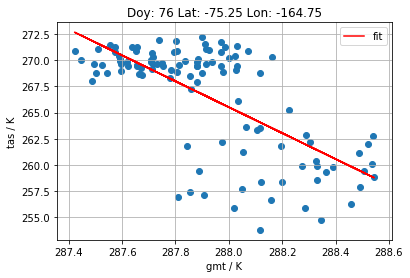

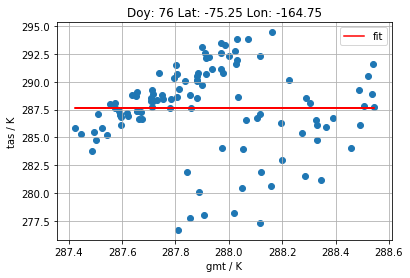

<Figure size 432x288 with 0 Axes>

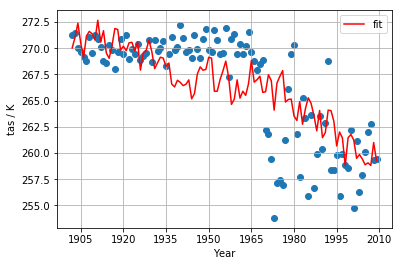

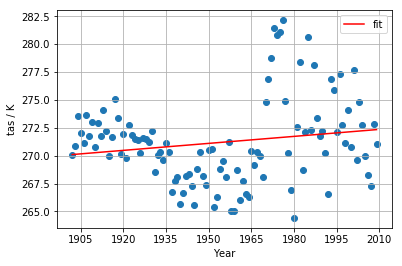

<Figure size 432x288 with 0 Axes>

In [49]:
min_ind = np.where(slope.data == slope.data.min())
indices = (min_ind[0][0], min_ind[1][0], min_ind[2][0])
regr_fit_gmt(slope, intercept, data, gmt, indices=indices)
regr_fit_gmt(slope, intercept, data, gmt, indices=indices, detrend=True)
regr_fit(slope, intercept, data, gmt, indices=indices)
regr_fit(slope, intercept, data, gmt, indices=indices, detrend=True)

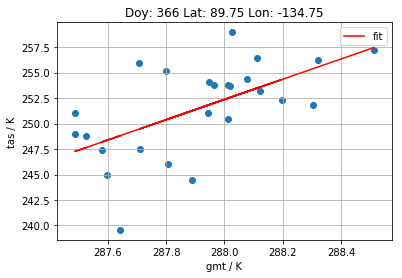

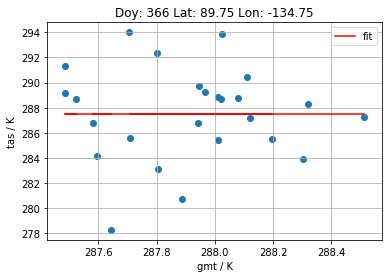

<Figure size 432x288 with 0 Axes>

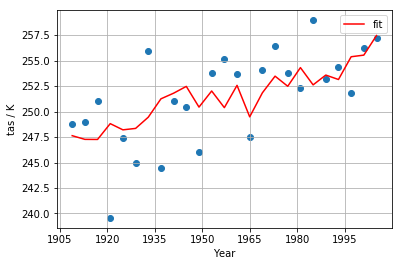

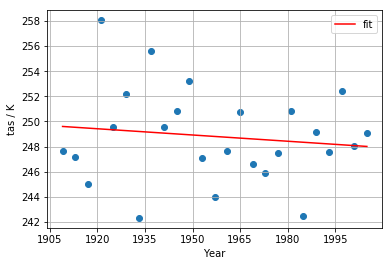

<Figure size 432x288 with 0 Axes>

In [50]:
max_ind = np.where(slope.data == slope.data.max())
indices = (max_ind[0][0], max_ind[1][0], max_ind[2][0])
regr_fit_gmt(slope, intercept, data, gmt, indices=indices)
regr_fit_gmt(slope, intercept, data, gmt, indices=indices, detrend=True)
regr_fit(slope, intercept, data, gmt, indices=indices)
regr_fit(slope, intercept, data, gmt, indices=indices, detrend=True)

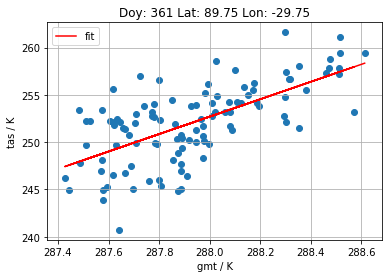

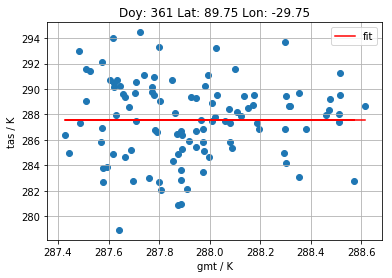

<Figure size 432x288 with 0 Axes>

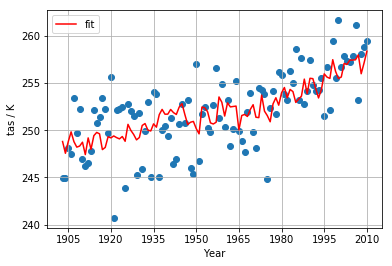

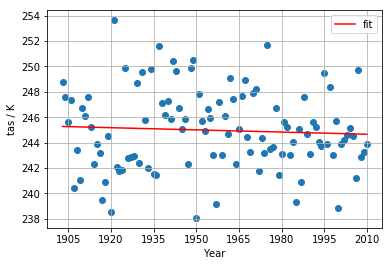

<Figure size 432x288 with 0 Axes>

In [51]:
max_ind = np.where(slope.data == slope.data[:365, :, :].max())
indices = (max_ind[0][0], max_ind[1][0], max_ind[2][0])
regr_fit_gmt(slope, intercept, data, gmt, indices=indices)
regr_fit_gmt(slope, intercept, data, gmt, indices=indices, detrend=True)
regr_fit(slope, intercept, data, gmt, indices=indices)
regr_fit(slope, intercept, data, gmt, indices=indices, detrend=True)

0
1
2
3
4
5


KeyboardInterrupt: 

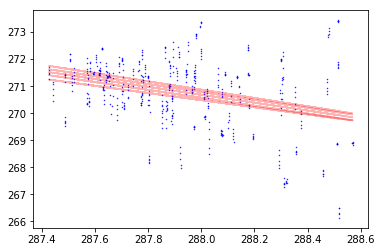

In [5]:
def regr_fit_gmt_long(slope, intercept, data, gmt, indices=(0, 0), detrend=False):
    #doy = slope.coord('day_of_year').points[indices[0]]
    lat = slope.coord('latitude').points[indices[0]]
    lon = slope.coord('longitude').points[indices[1]]
    for doy in range(366):
        print(doy)
        s = slope[doy, indices[0], indices[1]]
        i = intercept[doy, indices[0], indices[1]]
        plot_data = data.extract(iris.Constraint(day_of_year=doy+1))
        plot_data = plot_data[:, indices[0], indices[1]]
        gmt_slice = gmt.extract(iris.Constraint(day_of_year=doy+1))
        fit = i.data + (s.data * gmt_slice.data)
        if detrend:
            plot_data = fit - plot_data.data + plot_data.data[1]
            fit = fit - fit + plot_data.data[1]
        # Plot the data of one point and fit the regression.
        plt.scatter(gmt_slice.data[1:-1], plot_data.data[1:-1], c='b', s=0.2)
        plt.plot(gmt_slice.data[1:-1], fit[1:-1], 'r', label='fit', alpha=0.3)
    plt.title('Doy: ' + str(doy) + ' Lat: ' + str(lat) + ' Lon: ' + str(lon))
    plt.xlabel('gmt / K')
    plt.ylabel(data.name() + ' / K')
    plt.legend(ncol=2)
    plt.grid(True)
    plt.axis('tight')
    iplt.show()
    plt.savefig('/home/bschmidt/data/visual/' + data.name() + '_gmt_long_doy' + 
                str(doy) + '_lat' + str(lat) + '_lon' + str(lon) + '.pdf',
               format='pdf')
    
def regr_fit_long(slope, intercept, data, gmt, indices=(0, 0), detrend=False):
    #doy = slope.coord('day_of_year').points[indices[0]]
    lat = slope.coord('latitude').points[indices[0]]
    lon = slope.coord('longitude').points[indices[1]]
    for doy in range(366):
        print(doy)
        s = slope[doy, indices[0], indices[1]]
        i = intercept[doy, indices[0], indices[1]]
        plot_data = data.extract(iris.Constraint(day_of_year=doy+1))
        plot_data = plot_data[:, indices[0], indices[1]]
        gmt_slice = gmt.extract(iris.Constraint(day_of_year=doy+1))
        fit = i.data + (s.data * gmt_slice.data)
        time_values = gmt_slice.coord('time').points/365 + 1901
        if detrend:
            plot_data = fit - plot_data.data + plot_data.data[1]
            fit = fit - fit + plot_data.data[1]
        # Plot the data of one point and fit the regression.
        plt.scatter(time_values[1:-1], plot_data.data[1:-1])
        plt.plot(time_values[1:-1], fit[1:-1], 'r', label='fit', alpha=0.3)
    plt.title('Doy: ' + str(doy) + ' Lat: ' + str(lat) + ' Lon: ' + str(lon))
    plt.xlabel('gmt / K')
    plt.ylabel(data.name() + ' / K')
    plt.legend(ncol=2)
    plt.grid(True)
    plt.axis('tight')
    iplt.show()
    plt.savefig('/home/bschmidt/data/visual/' + data.name() + '_gmt_long_doy' + 
                str(doy) + '_lat' + str(lat) + '_lon' + str(lon) + '.pdf',
               format='pdf')
min_ind = np.where(slope.data == slope.data.min())
indices = (min_ind[1][0], min_ind[2][0])
regr_fit_gmt_long(slope, intercept, data, gmt, indices=indices)

In [ ]:
def ts_plot(slope, intercept, data, gmt, constraints=(1, 0, 0)):
    slope = slope[constraints]
    intercept = intercept[constraints]
    fit = intercept.data + (slope.data * gmt.data)
    iplt.plot(fit[1:])
    plt.legend(ncol=2)
    plt.grid(True)
    plt.axis('tight')
    iplt.show()


ts_plot(slope, intercept, data, gmt)

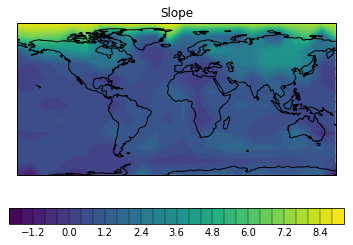

In [16]:

# Take a 2d slice of slope for one doy and plot as filled contour
slope_2d = slope[1, :, :]
contour = qplt.contourf(slope_2d, 30)
plt.gca().coastlines()
#plt.clabel(contour, inline=False)
plt.show()

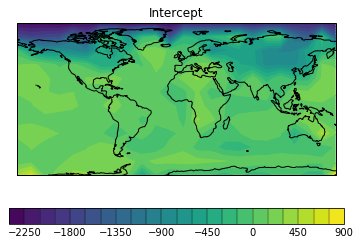

In [17]:
# Take a 2d slice of intercept for one doy and plot as filled contour
intercept_2d = intercept[1, :, :]
contour = qplt.contourf(intercept_2d, 30)
plt.gca().coastlines()
#plt.clabel(contour, inline=False)
plt.show()